<a target="_blank" href="https://colab.research.google.com/github/jeremyadamsfisher/ddpm_inversion/blob/main/ddpm_inversion.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
# !pip -q install diffusers["torch"] transformers

In [39]:
import math

import matplotlib.pyplot as plt
import torch
from diffusers import PNDMScheduler, StableDiffusionPipeline
from PIL import Image
from torchvision import transforms
from tqdm import tqdm

# **An Edit Friendly DDPM Noise Space: Inversion and Manipulations**

[Paper link](https://arxiv.org/abs/2304.06140)

> This is a blog post draft

Diffusion models are a fascinating realm of deep learning research. Unlike Transformers, where training and inference processes are quite similar and the focus lies primarily on scaling, diffusion models present a unique scenario. Their training and inference algorithms differ significantly, and are composed of an array of interweaving models and algorithms. Considering their internal hetergeneity and complexity, it's remarkable that diffusion models function at all.

In this notebook, we will discuss a noteworthy paper that introduces a simple yet intriguing concept: image-to-latent-code inversion. This process allows us to edit an image by modifying its corresponding latent code through a provided prompt.

The technique of image-to-latent-code inversion has a rich history, notably gaining popularity within the context of StyleGAN literature. StyleGANs involve mapping a multivariate normal distribution to an image distribution. The process involves the following steps:

1. Sample a random "latent" vector sampled from a normal distribution.
2. Compute the difference (like MSE or FID) between the desired image and the image generated by propagating the latent vector through the network.
3. Backpropagating through the network, updating only the "latent" vector while keeping the model weights frozen.
4. Repeating the steps 2-3 until convergence

Ultimately, this results in obtaining a latent code that faithfully represents the original image. By traversing different directions in the latent space, it becomes possible to manipulate various attributes of the image, such as age, hair length, or eye color—an impressive achievement for its time.

However, diffusion models lack the obvious internal structure that StyleGANs possess, making the concept of a latent code less evident in this context. Nonetheless, the potential for applying this concept is an exciting and promising path for researchers.


https://github.com/eladrich/pixel2style2pixel

In [40]:
T_SKIP = 31
CFG_SCALE_TGT = 15

In [41]:
η = 1  # DDPM (η=1) vs DDIM (η=0)
N_DIFFUSION_STEPS = 100
DEVICE = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available
    else "cpu"
)
MODEL_ID = "CompVis/stable-diffusion-v1-4"
CFG_SCALE_SRC = 3.5
INITIAL_IMAGE = "horse_mud.jpg"
PROMPT_SRC = "a photo of a horse"
PROMPT_TGT = "a photo of a zebra"

In [42]:
rng = torch.manual_seed(42)
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID).to(DEVICE)
pipe.scheduler.set_timesteps(N_DIFFUSION_STEPS)
img = Image.open(INITIAL_IMAGE)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


In [43]:
VAE_TO_UNET_SCALING_FACTOR = 0.18215


def compress(img):
    """Project pixels into latent space"""

    to_tensor = transforms.ToTensor()
    img = to_tensor(img).unsqueeze(0).to(DEVICE)
    img = img * 2 - 1  # Note scaling
    with torch.no_grad():
        latents = pipe.vae.encode(img)
    return VAE_TO_UNET_SCALING_FACTOR * latents.latent_dist.sample()


def decompress(latents):
    """Project latents into pixel space"""

    with torch.no_grad():
        img = pipe.vae.decode(latents / VAE_TO_UNET_SCALING_FACTOR).sample
    img = (img / 2 + 0.5).clamp(0, 1)
    # color dimension goes last for matplotlib
    img = img.permute(0, 2, 3, 1)
    img = img.cpu().numpy().squeeze()
    return img

In [44]:
# Compress the image into the latent representation
x0 = compress(img)
x0.shape

torch.Size([1, 4, 64, 64])

In [45]:
def tokenize_and_encode(prompt, max_length):
    prompt_tokens = pipe.tokenizer(
        prompt,
        padding="max_length",
        max_length=max_length,
        truncation=True,
        return_tensors="pt",
    )
    with torch.no_grad():
        return pipe.text_encoder(prompt_tokens.input_ids.to(DEVICE)).last_hidden_state


def embed_prompt(prompt):
    cond_embedding = tokenize_and_encode(prompt, pipe.tokenizer.model_max_length)
    _, max_length, _ = cond_embedding.shape
    uncond_embedding = tokenize_and_encode("", max_length)
    return torch.cat([cond_embedding, uncond_embedding])

In [46]:
# Get the prompt embedding
prompt_embedding_src = embed_prompt(PROMPT_SRC)
prompt_embedding_src.shape

torch.Size([2, 77, 768])

`alphas_cumprod` is defined somewhat clumsily for all possible total time steps, and is reordered when indexed by the specific `pipe.scheduler.timesteps` for our run. Therefore, we define `ᾱs` such that `ᾱs[t]` corresponds to the $\bar{\alpha}_t$ for a solver with `N_DIFFUSION_STEPS`.

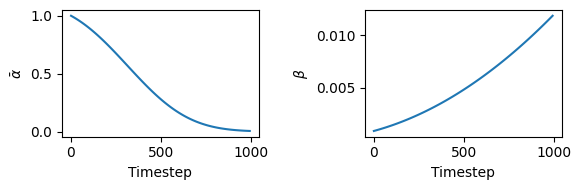

In [47]:
ᾱs = pipe.scheduler.alphas_cumprod[pipe.scheduler.timesteps]
βs = pipe.scheduler.betas[pipe.scheduler.timesteps]
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(6, 2))
ax0.plot(pipe.scheduler.timesteps, ᾱs)
ax0.set(xlabel="Timestep", ylabel=r"$\bar{\alpha}$")
ax1.plot(pipe.scheduler.timesteps, βs)
ax1.set(xlabel="Timestep", ylabel=r"$\beta$")
fig.tight_layout()

With that convenience variable, we implement equation 2, which is the crux of the algorithm.

This is the first loop, calculating $x_i \forall i \in \{1 \dots T\}$

In [11]:
xts = []  # Ordered from x_T to x_0
for ᾱ_t in ᾱs:
    Ɛ̃ = torch.rand_like(x0, device=DEVICE)
    xt = torch.sqrt(ᾱ_t) * x0 + torch.sqrt(1 - ᾱ_t) * Ɛ̃
    xts.append(xt)
len(xts)

101

In [12]:
def plot_images(latents, timesteps, rows, cols):
    assert len(latents) <= rows * cols
    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    for t, xt, ax in zip(timesteps, latents, axes.flatten()):
        img = decompress(xt)
        ax.imshow(img)
        ax.set(title=r"$x_{{{}}}$".format(t))
    for ax in axes.flatten():
        ax.axis("off")
    fig.tight_layout()

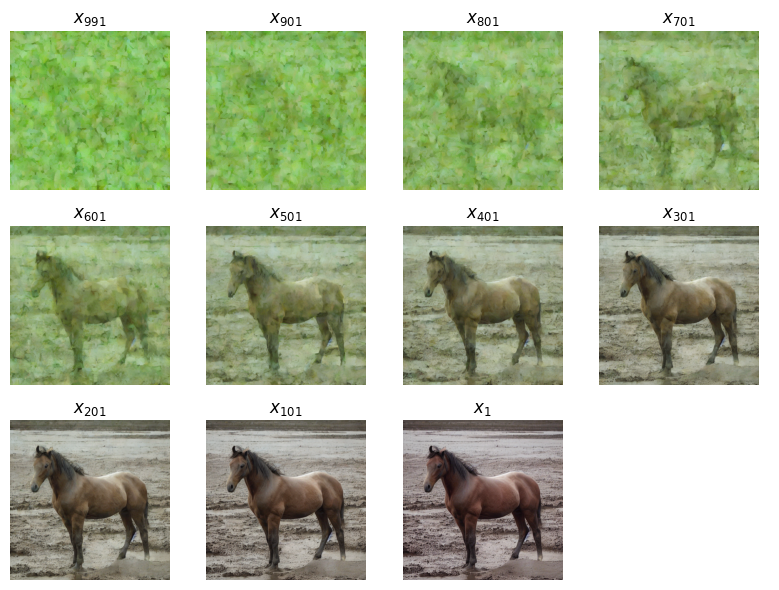

In [13]:
plot_images(xts[::10], pipe.scheduler.timesteps[::10], rows=3, cols=4)

The second loop calculates $z_i \forall i \in \{1 \dots T\}$ for $z$ in the **reverse** diffusion process. This is defined:

$$
x_{t-1} = \hat{\mu}_t(x_t) + \sigma_t z_t
$$

where $z \sim \mathcal{N}(0, I)$ (i.e., $z$ is a standard normal vector). Therefore, $z$ can be extracted like so:

$$
\begin{align}
x_{t-1} &= \hat{\mu}_t(x_t) + \sigma_t z_t \\
-\sigma_t z_t &= \hat{\mu}_t(x_t) - x_{t-1} \\
z_t &= \frac{ \hat{\mu}_t(x_t) - x_{t-1} }{ -\sigma_t } \\
z_t &= \frac{ x_{t-1} - \hat{\mu}_t(x_t) }{ \sigma_t } \\
\end{align}
$$

We also define $\hat{\mu}_t(x_t)$ like so:

$$
\hat{\mu}_t(x_t) = \sqrt{\bar{\alpha}_{t-1}}P(f_t(x_t)) + D(f_t(x_t))
$$

$f_t$ is a neural network that predicts $\epsilon$ using classifier-free guidance

In [14]:
@torch.no_grad()
def f_t(
    xt,  # (1, channels, sample size, sample size)
    prompt_embedding,  # (2, seq length, channels)
    g,  # (guidance scale)
    t,
):
    sample = pipe.unet(torch.cat([xt, xt]), t, prompt_embedding).sample
    c, u = sample.chunk(2)
    return c + g * (c - u)

$P$ uses $f_t$ to predict $x_0$ like so:

$$
\hat{x_0}=P(f_t(x_t)) = x_t - \sqrt{1-\bar{\alpha}}f_t(x_t)
$$

In [15]:
def P(xt, x0_pred, ᾱ_t):
    return xt - torch.sqrt(1 - ᾱ_t) * x0_pred

And $D$ is the direction from $x_t$ to $x_0$ and is defined as:

$$
D = \sqrt{1-\bar{\alpha_{t-1}} - (\sigma_t)^2} f_t(x_t)
$$

Note that $\sigma_t$ is the variance at $t$ and is defined as $\eta \frac{\beta_t(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}$.

In [16]:
def σ_t(t):
    ᾱ_t = pipe.scheduler.alphas_cumprod[t]
    ᾱ_t_minus_1 = pipe.scheduler.alphas_cumprod[t + 1]
    ƀ_t = pipe.scheduler.betas[t]
    return η * ƀ_t * (1 - ᾱ_t_minus_1) / (1 - ᾱ_t)


def D(η, t, x0_pred):
    ᾱ_t_minus_1 = pipe.scheduler.alphas_cumprod[t + 1]
    σ_t_ = σ_t(t)
    return torch.sqrt(1 - ᾱ_t_minus_1 - σ_t_**2) * x0_pred

Bringing this altogether, here we can compute $z_i \forall i \in \{1, \dots, T\}$. Notice, we need to avoid error accumulation by recomputing $x_{t-1}$ for each step. This makes the iteration a bit more complicated.

In [17]:
xts_ = xts.copy()  # copying xts make this cell idempotent

zts = []  # Ordered from z_T to z_0
iter_ = zip(
    pipe.scheduler.timesteps,
    reversed(ᾱs),
    reversed(ᾱs[:-1]),
)
iter_ = tqdm(iter_, total=len(pipe.scheduler.timesteps), unit="timestep")
for i, (t, ᾱ_t, ᾱ_t_minus_1) in enumerate(iter_):
    xt, xt_minus_1 = xts_[i], xts_[i + 1]
    f_t_x_t = f_t(xt, prompt_embedding_src, CFG_SCALE_SRC, t)
    x0_pred = P(xt, f_t_x_t, ᾱ_t)
    D_f_t_x_t = D(η, t, f_t_x_t)
    μ_t_x_t = torch.sqrt(ᾱ_t_minus_1) * x0_pred + D_f_t_x_t
    σ_t_ = σ_t(t)
    z_t = (xt_minus_1 - μ_t_x_t) / σ_t_
    zts.append(z_t)
    # Recompute x_{t-1} to avoid error accumulation
    xts_[i + 1] = μ_t_x_t + σ_t_ * z_t

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 100/101 [02:15<00:01,  1.36s/timestep]


In [18]:
def plot_latents(latents, timesteps, scale=1):
    rows = len(latents)
    cols = 5
    fig, axes = plt.subplots(rows, cols, figsize=(scale * cols, scale * rows))
    for ax in axes.flatten():
        ax.axis("off")
    for i, (t, xt) in enumerate(zip(timesteps, latents)):
        for col in range(4):
            im = xt[0, col, :, :].cpu()
            ax = axes[i, col]
            ax.imshow(im, cmap="plasma")
            ax.set(title="$z_{{{}}}$".format(t))
        ax = axes[i, 4]
        ax.hist(xt.reshape(-1).cpu())
        ax.set(xlabel="logits", ylabel="count")
        ax.axis("on")
    fig.tight_layout()

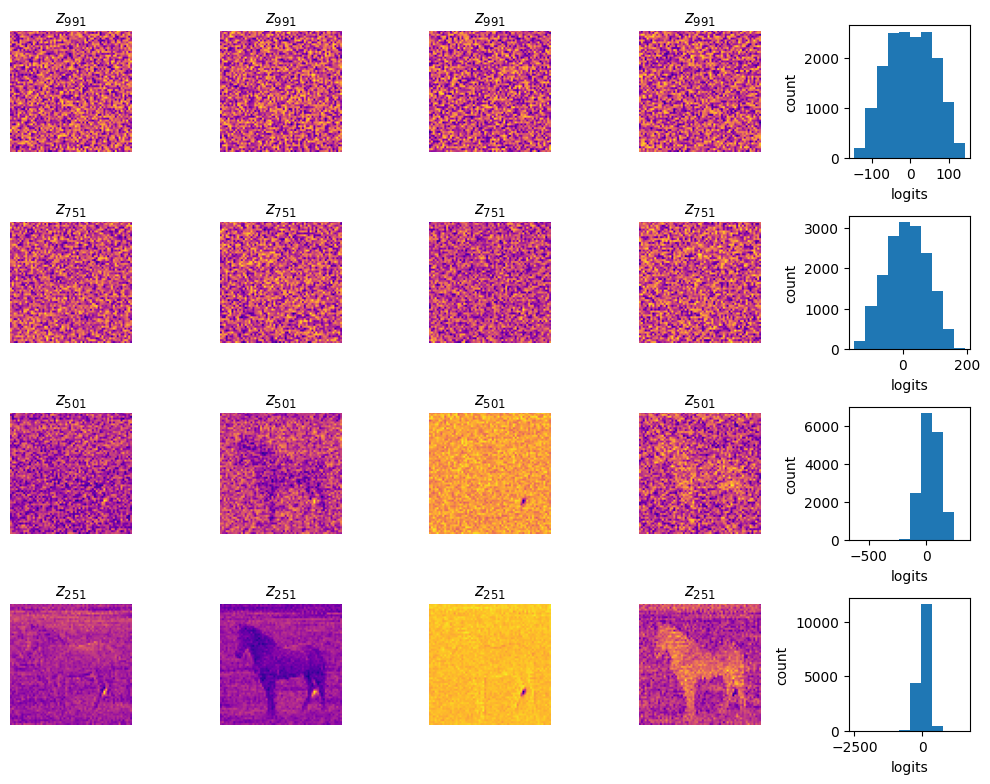

In [19]:
plot_latents(zts[::25], pipe.scheduler.timesteps[::25], 2)

To edit with this latent code, we fix the noise maps and generate images with the target prompt from $T$ to $T_{skip}$. Recall, $x_{t-1} = \hat{\mu}_t(x_t) + \sigma_t z_t$

In [ ]:
T_SKIP = 641  # ????

prompt_embedding_tgt = embed_prompt(PROMPT_TGT)

xts_editted = xts.copy()
ts = pipe.scheduler.timesteps[:N_DIFFUSION_STEPS]
pbar = tqdm(enumerate(ts), total=len(ts), unit="timestep")
for i, t in pbar:
    xt = xts_editted[i]
    zt = zts[i]
    ᾱ_t = ᾱs[i]
    ᾱ_t_minus_1 = ᾱs[i + 1]

    # Recall that t begins with ~1000 and ends with 0
    prompt_embedding = prompt_embedding_src if t < T_SKIP else prompt_embedding_tgt
    scale = CFG_SCALE_SRC if t < T_SKIP else CFG_SCALE_TGT
    pbar.set_description("using source prompt" if t < T_SKIP else "using target prompt")

    f_t_x_t = f_t(xt, prompt_embedding, scale, t)
    x0_pred = P(xt, f_t_x_t, ᾱ_t)
    D_f_t_x_t = D(η, t, f_t_x_t)
    μ_t_x_t = torch.sqrt(ᾱ_t_minus_1) * x0_pred + D_f_t_x_t
    σ_t_ = σ_t(t)
    x_t_minus_1 = μ_t_x_t + σ_t_ * zt

    xts_editted[i + 1] = x_t_minus_1

In [ ]:
plot_images(xts_editted[::10], ts[::10], rows=3, cols=4)